# Year Prediction MSD

HANNA Marianne

## Introduction

Dans ce projet d'analyse de données en python, nous avons dû utiliser le jeu de données "Year Prediction Music Song Dataset" de l'ICS. Le sujet de ce jeu de données est la prédiction de l'année de sortie d'une chanson à partir de caractéristiques audio. Les chansons sont pour la plupart des titres commerciaux occidentaux, allant de 1922 à 2011, avec un pic dans les années 2000.

Le dataset est composé de 90 attributs avec 12 attributs qui correspondent à la moyenne du timbre et 78 attributs pour la covariance du timbre. 
La première valeur est l'année, allant de 1922 à 2011.

Les caractéristiques sont extraites des 'timbres' de l'API The Echo Nest.


En utilisant ses caractéristiques, ce projet applique le modèle de régression linéaire. Ces caractéristiques sont utilisées pour construire une matrice modèle de prédicteurs et pour prédire les années de sortie des chansons en utilisant le RSS et le "cross-validation".


## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from numpy import mean
from numpy import std
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.svm import SVR
from sklearn import svm
from matplotlib import rcParams
from sklearn.datasets import make_classification

#Affichage avec la bibliothèque graphique intégrée à Notebook
%matplotlib inline


## Data collection


In [2]:
#On récupere le dataset et on rajoute le nom des colonnes, la premiere correspond à l'année, les 12 suivantes au "Timbre average" et les 78 autres colonnes au "Timbre Covariance"
df = pd.read_csv("YearPredictionMSD.csv", encoding="UTF-8", delimiter=',', quotechar='|')

timbreAVG_list = ['TimbreAVG{}'.format(x) for x in range(0,12)]
timbreCOV_list = ['TimbreCOV{}'.format(x) for x in range(0,78)]

df.columns = [x for x in ['Date']+timbreAVG_list+timbreCOV_list]
df



,Date,TimbreAVG0,TimbreAVG1,TimbreAVG2,TimbreAVG3,TimbreAVG4,TimbreAVG5,TimbreAVG6,TimbreAVG7,TimbreAVG8,TimbreAVG9,TimbreAVG10,TimbreAVG11,TimbreCOV0,TimbreCOV1,TimbreCOV2,TimbreCOV3,TimbreCOV4,TimbreCOV5,TimbreCOV6,TimbreCOV7,TimbreCOV8,TimbreCOV9,TimbreCOV10,TimbreCOV11,TimbreCOV12,TimbreCOV13,TimbreCOV14,TimbreCOV15,TimbreCOV16,TimbreCOV17,TimbreCOV18,TimbreCOV19,TimbreCOV20,TimbreCOV21,TimbreCOV22,TimbreCOV23,TimbreCOV24,TimbreCOV25,TimbreCOV26,...,TimbreCOV38,TimbreCOV39,TimbreCOV40,TimbreCOV41,TimbreCOV42,TimbreCOV43,TimbreCOV44,TimbreCOV45,TimbreCOV46,TimbreCOV47,TimbreCOV48,TimbreCOV49,TimbreCOV50,TimbreCOV51,TimbreCOV52,TimbreCOV53,TimbreCOV54,TimbreCOV55,TimbreCOV56,TimbreCOV57,TimbreCOV58,TimbreCOV59,TimbreCOV60,TimbreCOV61,TimbreCOV62,TimbreCOV63,TimbreCOV64,TimbreCOV65,TimbreCOV66,TimbreCOV67,TimbreCOV68,TimbreCOV69,TimbreCOV70,TimbreCOV71,TimbreCOV72,TimbreCOV73,TimbreCOV74,TimbreCOV75,TimbreCOV76,TimbreCOV77
0,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
1,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
2,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
3,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
4,2001,50.54767,0.31568,92.3506

In [3]:
df.head()

,Date,TimbreAVG0,TimbreAVG1,TimbreAVG2,TimbreAVG3,TimbreAVG4,TimbreAVG5,TimbreAVG6,TimbreAVG7,TimbreAVG8,TimbreAVG9,TimbreAVG10,TimbreAVG11,TimbreCOV0,TimbreCOV1,TimbreCOV2,TimbreCOV3,TimbreCOV4,TimbreCOV5,TimbreCOV6,TimbreCOV7,TimbreCOV8,TimbreCOV9,TimbreCOV10,TimbreCOV11,TimbreCOV12,TimbreCOV13,TimbreCOV14,TimbreCOV15,TimbreCOV16,TimbreCOV17,TimbreCOV18,TimbreCOV19,TimbreCOV20,TimbreCOV21,TimbreCOV22,TimbreCOV23,TimbreCOV24,TimbreCOV25,TimbreCOV26,...,TimbreCOV38,TimbreCOV39,TimbreCOV40,TimbreCOV41,TimbreCOV42,TimbreCOV43,TimbreCOV44,TimbreCOV45,TimbreCOV46,TimbreCOV47,TimbreCOV48,TimbreCOV49,TimbreCOV50,TimbreCOV51,TimbreCOV52,TimbreCOV53,TimbreCOV54,TimbreCOV55,TimbreCOV56,TimbreCOV57,TimbreCOV58,TimbreCOV59,TimbreCOV60,TimbreCOV61,TimbreCOV62,TimbreCOV63,TimbreCOV64,TimbreCOV65,TimbreCOV66,TimbreCOV67,TimbreCOV68,TimbreCOV69,TimbreCOV70,TimbreCOV71,TimbreCOV72,TimbreCOV73,TimbreCOV74,TimbreCOV75,TimbreCOV76,TimbreCOV77
0,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
1,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
2,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
3,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
4,2001,50.54767,0.31568,92.3506

In [4]:
df.shape

(515344, 91)

In [5]:
df.describe()

,Date,TimbreAVG0,TimbreAVG1,TimbreAVG2,TimbreAVG3,TimbreAVG4,TimbreAVG5,TimbreAVG6,TimbreAVG7,TimbreAVG8,TimbreAVG9,TimbreAVG10,TimbreAVG11,TimbreCOV0,TimbreCOV1,TimbreCOV2,TimbreCOV3,TimbreCOV4,TimbreCOV5,TimbreCOV6,TimbreCOV7,TimbreCOV8,TimbreCOV9,TimbreCOV10,TimbreCOV11,TimbreCOV12,TimbreCOV13,TimbreCOV14,TimbreCOV15,TimbreCOV16,TimbreCOV17,TimbreCOV18,TimbreCOV19,TimbreCOV20,TimbreCOV21,TimbreCOV22,TimbreCOV23,TimbreCOV24,TimbreCOV25,TimbreCOV26,...,TimbreCOV38,TimbreCOV39,TimbreCOV40,TimbreCOV41,TimbreCOV42,TimbreCOV43,TimbreCOV44,TimbreCOV45,TimbreCOV46,TimbreCOV47,TimbreCOV48,TimbreCOV49,TimbreCOV50,TimbreCOV51,TimbreCOV52,TimbreCOV53,TimbreCOV54,TimbreCOV55,TimbreCOV56,TimbreCOV57,TimbreCOV58,TimbreCOV59,TimbreCOV60,TimbreCOV61,TimbreCOV62,TimbreCOV63,TimbreCOV64,TimbreCOV65,TimbreCOV66,TimbreCOV67,TimbreCOV68,TimbreCOV69,TimbreCOV70,TimbreCOV71,TimbreCOV72,TimbreCOV73,TimbreCOV74,TimbreCOV75,TimbreCOV76,TimbreCOV77
count,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,...,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000,515344.000000
mean,1998.397077,43.387113,1.289515,8.658222,1.164110,-6.553580,-9.521968,-2.391046,-1.793215,3.727868,1.882393,-0.146534,2.546073,33.714051,2439.362923,1967.736175,1514.861487,910.982318,879.147682,603.737972,517.579881,393.962491,325.733439,288.885451,291.973457,43.032069,43.315573,-46.449282,-27.672930,14.958705,44.514981,5.131793,24.034288,9.498812,-4.178867,0.499461,72.652409,-51.441096,117.921446,-189.881181,...,6.378572,28.294145,12.772240,1.700397,-10.205161,64.101428,104.822084,-0.026606,38.678065,-27.989953,3.301761,0.307112,-0.478808,-138.223307,-0.695907,0.242652,3.151748,27.642661,31.822251,-0.835963,-8.931509,4.849342,-27.347683,-11.938830,-21.572162,-5.576195,-23.304345,31.113085,-104.974893,26.962368,15.755411,-73.461537,41.542388,37.934163,0.315750,17.669292,-26.315520,4.458653,20.035229,1.329104
std,10.931056,6.067557,51.580393,35.268505,16.322802,22.860803,12.857763,14.571853,7.963822,10.582869,6.530235,4.370850,8.320195,22.259630,1749.367533,1261.485221,1092.831512,475.708151,576.866141,317.499361,309.364790,214.013617,165.699431,186.960726,153.475717,121.429595,715.759665,544.880358,218.368663,163.215874,134.887935,99.088215,71.810003,74.411752,53.517088,42.490436,107.912685,415.039487,453.399584,260.645536,...,93.555753,75.049336,69.981917,83.278722,57.806647,273.827429,311.135600,266.774270,169.072326,144.083173,59.447259,49.181472,37.675458,308.187683,222.198706,128.141075,99.921046,116.696274,106.360041,36.799228,251.606995,229.060635,163.782776,63.288946,64.691606,26.358200,268.191172,144.156341,201.137705,123.848010,32.099666,175.619058,122.228915,95.050718,16.161780,114.428002,173.977455,13.346567,185.558415,22.088598
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.

La première chose à faire est d'explorer notre Dataset, pour cela, j'utilise 3 importantes fonctions qui sont :

- shape: La structure du Dataset, on a 515345 lignes et 91 colonnes. 
- head() : Retourne les 5 premières lignes 
- describe(): Nous donne quelques observations statistiques de base (comme la moyenne, la médiane, le quartile, le min/max) sur l'ensemble de données.

Regardons maintenant si notre DataFrame comporte des valeurs manquantes

### Valeur manquante

In [6]:
missing_value = (df.isnull().sum())
print(missing_value[missing_value > 0])

Series([], dtype: int64)


Il n'y a pas de valeur manquante, on va maintenant pouvoir visualiser nos données. 

## Data-visualization

Analysons nos données, on commence par regarder le nombre de musique sortie par rapport à l'année de sortie

Text(0, 0.5, 'Nombre de musique')

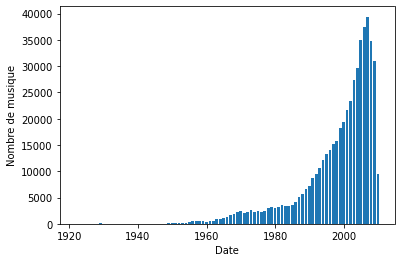

In [7]:
nb_songs = {}
for y in range(1922,2012):
    nb_songs[y] = len(df[df['Date']==y])
date = range(1922,2011)
values = [nb_songs[y] for y in date]
plt.bar(date, values, align='center')
plt.xlabel("Date")
plt.ylabel("Nombre de musique")

On peut voir qu'au fil des années, il y a de plus en plus de musiques qui sortent, notamment dans les années 2000. En effet, nous avons un pic au début des années 2000, plus précisement en 2007. 

Nous avons une asymétrie négative.

##### Matrice de corrélation

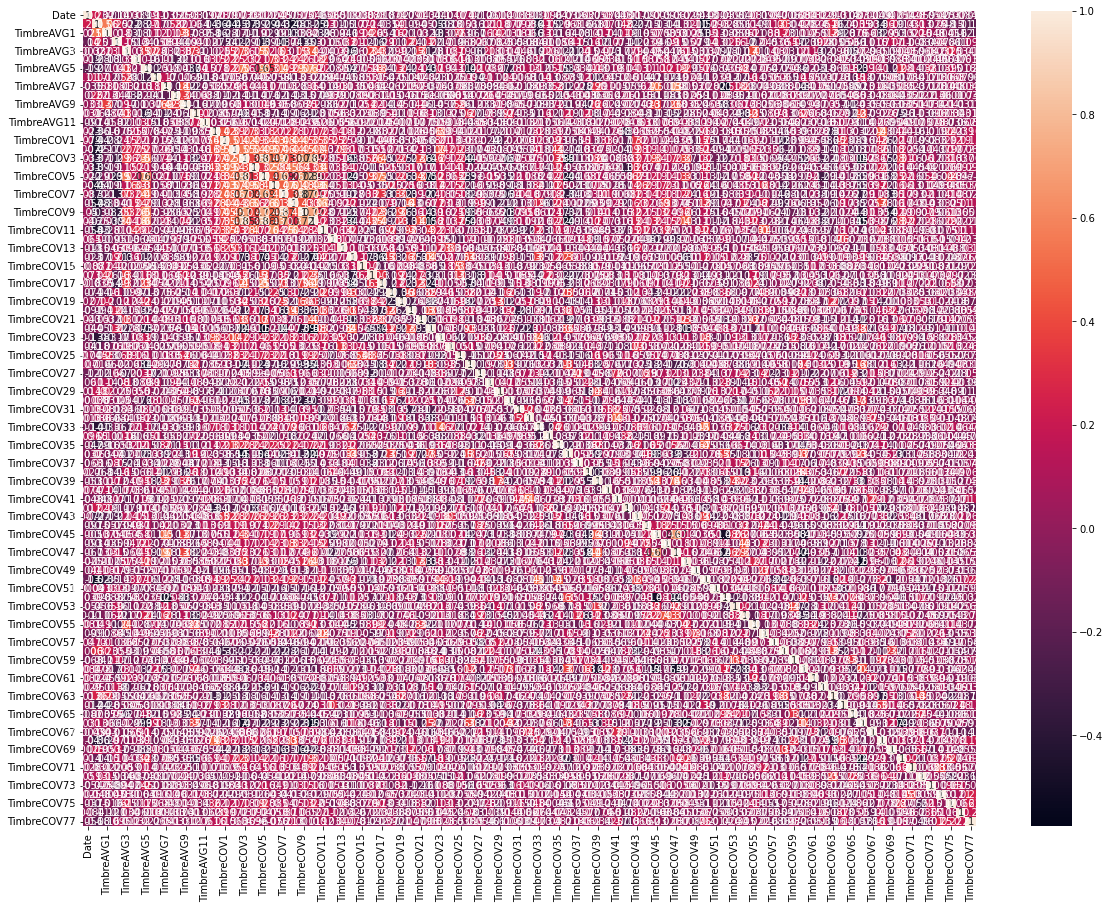

In [8]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(),annot=True)
plt.show()

Comme nous pouvons le constater, nous ne pouvons pas vraiment tirer de conclusions de cette matrice de confusion car elle comporte trop de variables. 

Nous avons seulement besoin des corrélations les plus importantes et surtout des corrélations entre l'étiquette cible et le reste des variables. 

__________________________________________________________________________________________________________________

Etant donnée que nous avons 90 attributs, cela représente beaucoup d'attribut, on va donc redimensionner notre dataset grâce au PCA. 

Avant cela, nous allons séparer notre train et notre test de notre jeu de données.  



---



## Séparation du Train et Test Set

On nous recommande de respecter la répartition du train / test suivante :

- train : premiers 463 715 exemples
- test : 51 630 derniers exemples

Cela permet d'éviter "l'effet producteur" en s'assurant qu'aucune chanson d'un artiste donné ne se retrouve à la fois dans l'ensemble de formation et de test.

In [9]:
# On sépare les attributs d'entrée et de sortie de notre dataset
X = df.iloc[:,1:]
Y = df.iloc[:,0]


# Train set
X_train = X.iloc[0:463715,:]
y_train = Y.iloc[0:463715]
# Test set
X_test = X.iloc[463715:,:]
y_test = Y.iloc[463715:]


In [10]:
y_train.shape

(463715,)

In [11]:
y_train.describe()

count    463715.000000
mean       1998.386108
std          10.939774
min        1922.000000
25%        1994.000000
50%        2002.000000
75%        2006.000000
max        2011.000000
Name: Date, dtype: float64

On peut voir que le minimum est atteint en 1922 et le maximum en 2011. 

Text(0.5, 1.0, 'Echantillons')

<Figure size 2160x576 with 0 Axes>

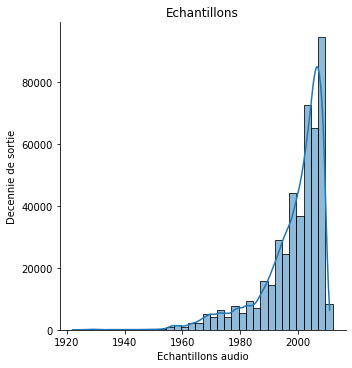

In [12]:
plt.figure(figsize=(30,8))
sns.displot(y_train,binwidth=2.5, kde=True)

plt.xlabel("Echantillons audio")
plt.ylabel("Decennie de sortie")
plt.title("Echantillons")

On retrouve bien notre analyse du dessus.

### Data visualization

### Pour chaque attribut

##### Histograme pour chaque attribut

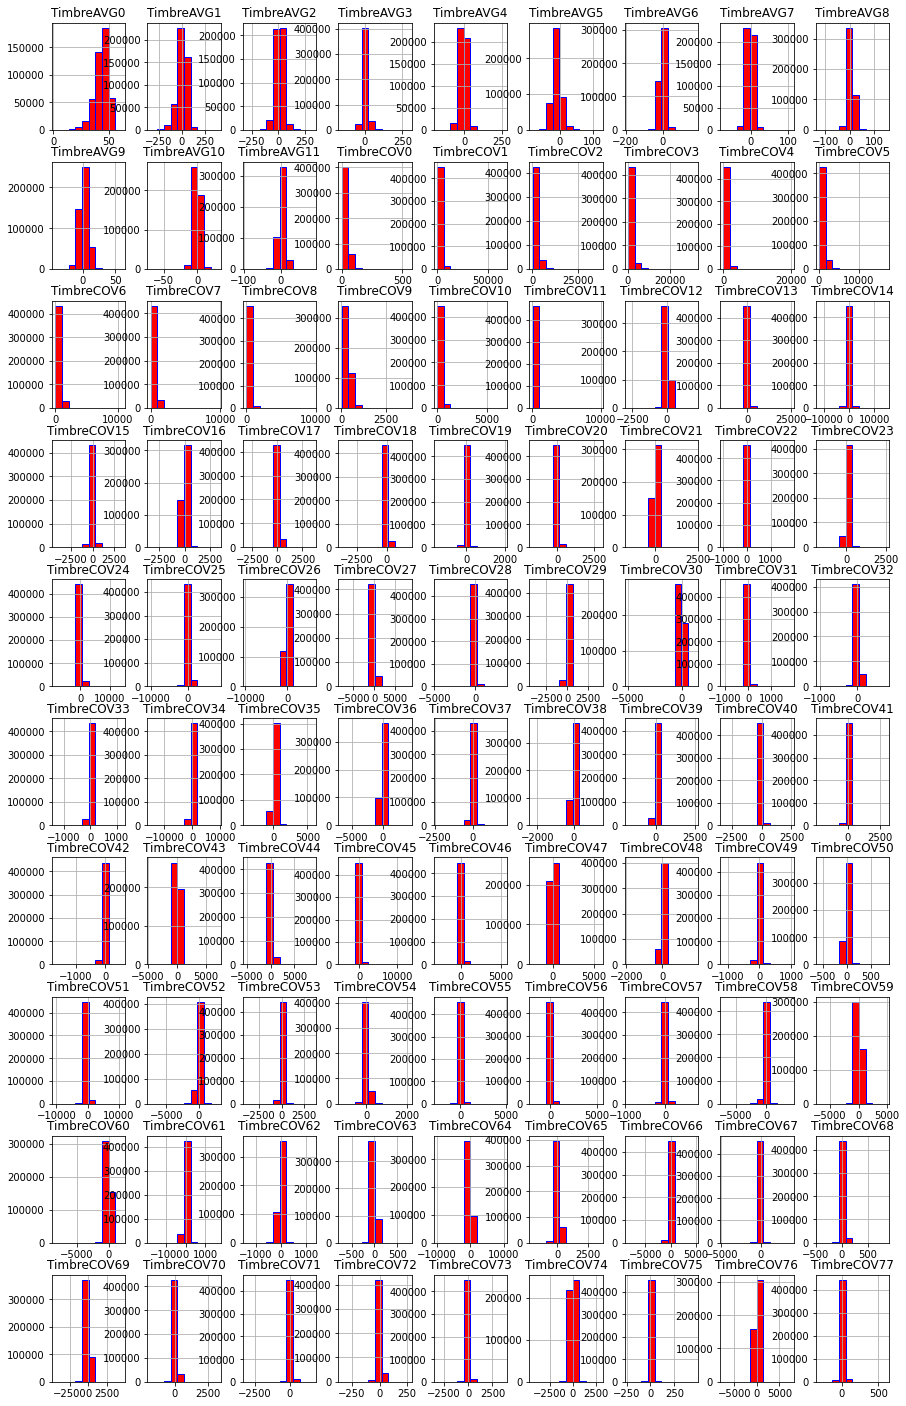

In [13]:
X_train.hist(figsize=(15,25),facecolor='red',edgecolor='blue')
pyplot.show()

#####  Plot de densité pour chaque attribut

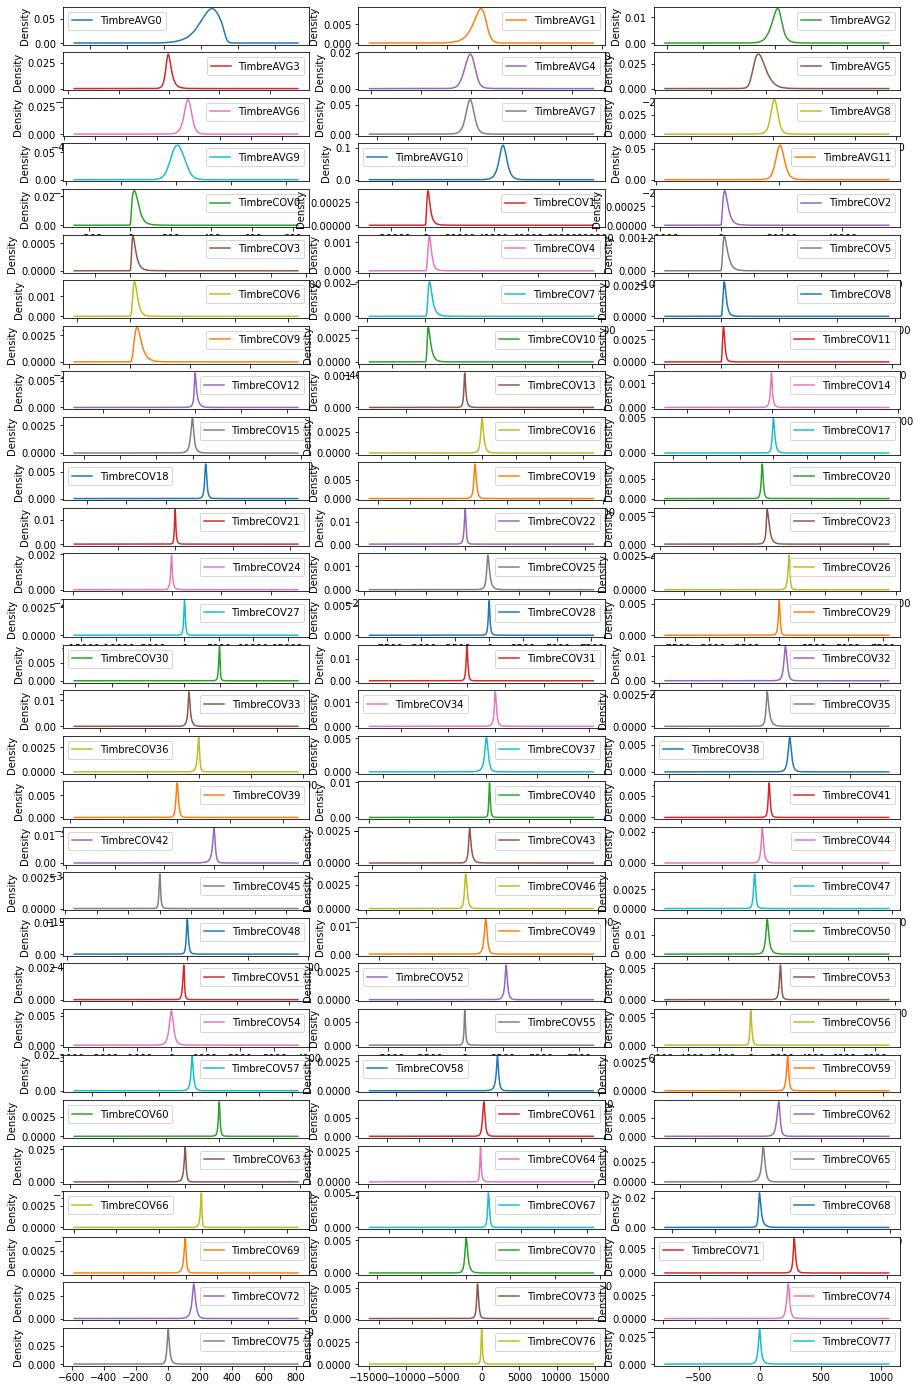

In [14]:
X_train.plot(figsize=(15,25), kind='density', layout=(30,3), subplots=True, sharex=False, sharey=False)
pyplot.show()

##### Box plot pour chaque attribut

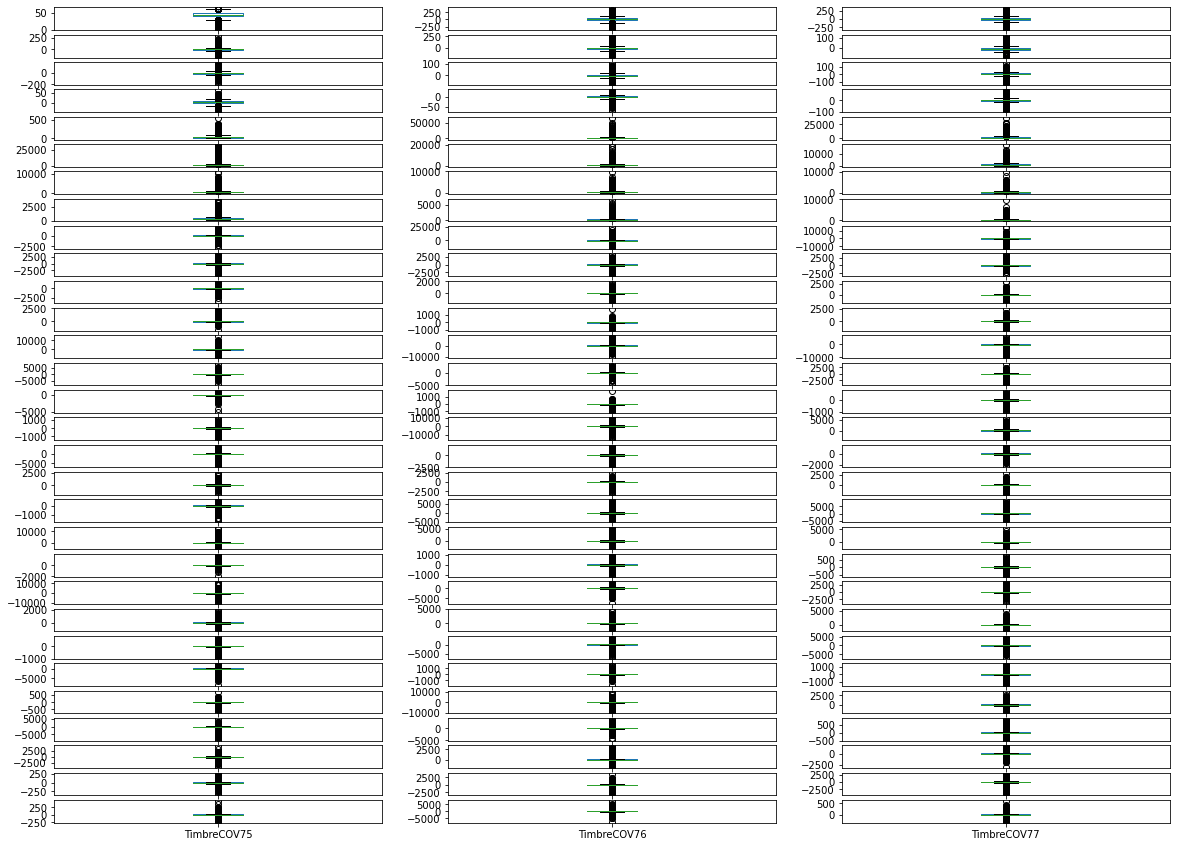

In [15]:
X_train.plot(figsize=(20,15),kind='box',  layout=(30,3), subplots=True, sharex=False, sharey=False)
pyplot.show()

### Pour comprendre les relations entre attribut

##### Matrice de correlation : corrélation entre les caractéristiques et la classe de sortie. 

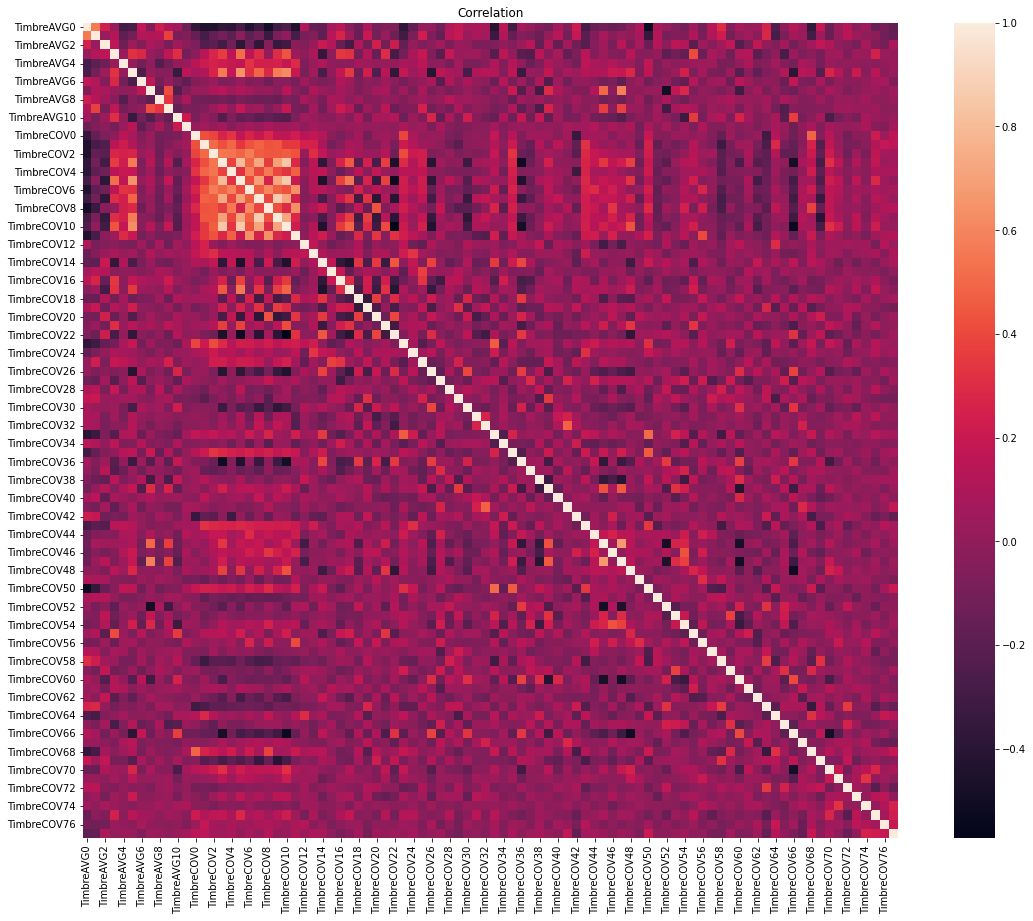

In [16]:
# Correlation entre la classe de sortie et les caractéristiques
corr = X_train.corr()
fig, ax = plt.subplots(figsize=(20,15)) 
plt.title("Correlation")
sns.heatmap(corr, square=True)
plt.show()

__________________________________________________________________________________________________________________

## Modeling

Première étape on crée un nouveau label

### Création d'un nouveal label

Ici on crée un nouveau label qui va regrouper les dates en décennie et ainsi, nous permettre d'analyser nos données. 

In [17]:
def decennie(date):
  return (int(date/10))*10

y_train = y_train.apply(lambda x: decennie(x))
y_test = y_test.apply(lambda x: decennie(x))

In [18]:
y_train.value_counts()

2000    269118
1990    112133
1980     37613
1970     22349
1960     10573
2010      8364
1950      2827
1940       295
1930       239
1920       204
Name: Date, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, "Echantillons d'audio par decennie")

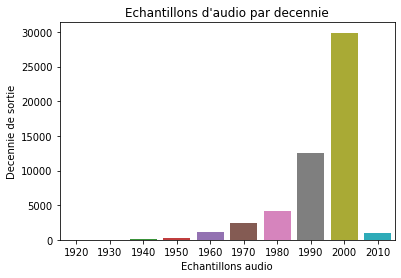

In [19]:
sns.countplot(y_test, data=df)
plt.xlabel("Echantillons audio")
plt.ylabel("Decennie de sortie")
plt.title("Echantillons d'audio par decennie")

Nous pouvons de nouveau apercevoir que le nombre d'échantillons d'audio augmentent exponentiellement, avec un pic dans les années 2000. 


Cependant, le nombre d'échantillons de données n'est pas uniforme pour toutes les décennies de sortie. Il y a trop peu d'échantillons de chansons sorties avant 1950.

### Normalisation des données

Chacune des caractéristiques prend un large éventail de valeurs et de distributions différentes.

Nous appliquons une mise à l'échelle MinMax à nos données.

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled,columns=X_train.columns)

Puis on va normaliser nos données grâce à "StandardScaler"

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [22]:
np.mean(X_test_scaler),np.std(X_test_scaler)

(0.0012559543427801028, 1.00598763555552)

### Réduction des données

Pour cela on utilise PCA, il s'agit d'un outil qui va nous permettre de réduire l'espace multidimensionnel. Il va nous permettre de garantir qu'il n'y aura aucune corrélation entre les fonctionnalités résultantes.

In [23]:
from sklearn.decomposition import PCA

pca = PCA(.90)

pca.fit(X_train_scaler)

PCA(n_components=0.9)

In [24]:
pca.n_components_

55

In [25]:
X_train_pca = pca.transform(X_train_scaler)
X_test_pca = pca.transform(X_test_scaler)

y_train_pca = y_train - min(y_train)
y_test_pca = y_test - min(y_test)

Grâce au PCA(.90) on peut voir que 90% de la variance correspond à 55 composantes principales 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


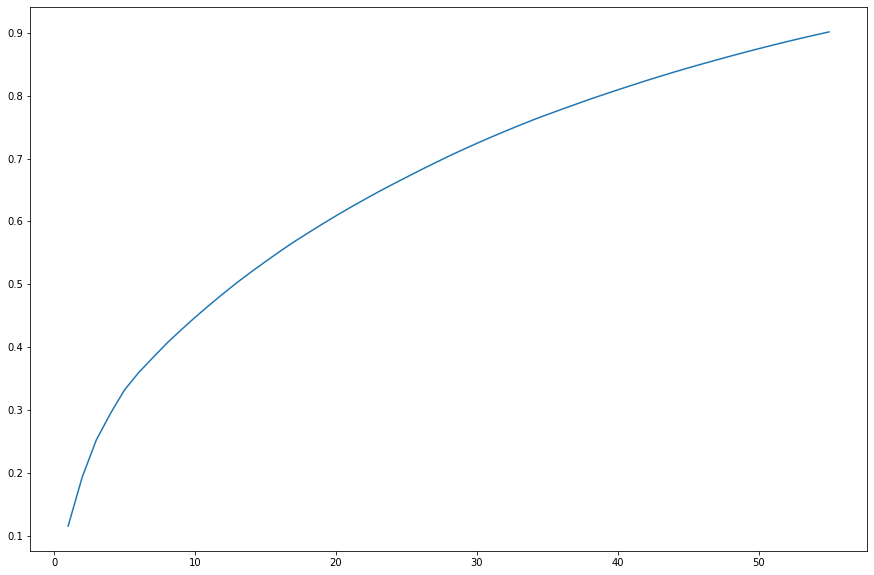

In [26]:
plt.figure(figsize=(15,10))
sns.lineplot(range(1,56),np.cumsum(pca.explained_variance_ratio_))
plt.show()



---



Maintenant que nos données sont prêtes nous allons choisir le meilleur modèle qui nous permettra de répondre à notre problématique, à savoir de prédire l'année de sortie d'une chanson à partir des caractéristiques audio.

### Modèles

Pour prédire la décennie de sortie d'une chanson à partir des caractéristiques audio, nous avons utilisé 6 modèles d'apprentissage automatique de regression différents : 
    
- Des algorithmes linéaire: Regression Lineaire et LASSO

- Des algorithmes non-linéaires: Arbre de décision et KNN

- Algorithme d'ensemble: Random Forest et eXtreme Gradient Boosting

**Regression Linéaire**

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score
from sklearn.metrics import explained_variance_score

model = LinearRegression()
linear_R_fit_pca = model.fit(X_train_pca, y_train_pca)
linear_R_score_pca = model.score(X_train_pca, y_train_pca)
linear_R_pred_pca = model.predict(X_test_pca)
linear_R_moy_pca = np.mean(np.absolute(linear_R_pred_pca-np.array(y_test_pca)))

linear_R_mse_pca = mean_squared_error(y_test_pca, linear_R_pred_pca)
linear_R_mae_pca = mean_absolute_error(y_test_pca, linear_R_pred_pca)
linear_R_medae_pca = median_absolute_error(y_test_pca, linear_R_pred_pca)
linear_R_r2_pca = r2_score(y_test_pca, linear_R_pred_pca)
linear_R_var_pca = explained_variance_score( y_test_pca, linear_R_pred_pca)

print("MSE : ", linear_R_mse_pca)
print("MEAN ABSOLUTE ERROR  : ", linear_R_mae_pca)
print("MEDIAN ABSOLUTE ERROR : ", linear_R_medae_pca)
print("R2 : ", linear_R_r2_pca)
print("VARIANCE : ", linear_R_var_pca)
print("Regression Lineaire Score : ", linear_R_score_pca)
print("Regression Lineaire Moyenne: ", linear_R_moy_pca)

MSE :  100.77798724565065
MEAN ABSOLUTE ERROR  :  7.4602101032749415
MEDIAN ABSOLUTE ERROR :  5.678418623277281
R2 :  0.12562744990605157
VARIANCE :  0.12564175922956677
Regression Lineaire Score :  0.12719225368757991
Regression Lineaire Moyenne:  7.4602101032749415


**LASSO**

In [28]:
from sklearn import linear_model

model = linear_model.Lasso(alpha=0.1)
lasso_fit_pca = model.fit(X_train_pca, y_train_pca)
lasso_score_pca = model.score(X_train_pca, y_train_pca)
lasso_pred_pca = model.predict(X_test_pca)
lasso_moy_pca = np.mean(np.absolute((lasso_pred_pca-np.array(y_test_pca))))

lasso_mse_pca = mean_squared_error(y_test_pca, lasso_pred_pca)
lasso_mae_pca = mean_absolute_error(y_test_pca, lasso_pred_pca)
lasso_medae_pca = median_absolute_error(y_test_pca, lasso_pred_pca)
lasso_r2_pca = r2_score(y_test_pca, lasso_pred_pca)
lasso_var_pca = explained_variance_score( y_test_pca, lasso_pred_pca)


print("MSE : ", lasso_mse_pca)
print("MEAN ABSOLUTE ERROR  : ", lasso_mae_pca)
print("MEDIAN ABSOLUTE ERROR : ", lasso_medae_pca)
print("R2 : ", lasso_r2_pca)
print("VARIANCE : ", lasso_var_pca)
print("LASSO Score : ", lasso_score_pca)
print("LASSO Moyenne: ", lasso_moy_pca)


MSE :  101.03723209009173
MEAN ABSOLUTE ERROR  :  7.4881442044352085
MEDIAN ABSOLUTE ERROR :  5.724575597751439
R2 :  0.12337818315715221
VARIANCE :  0.12339591850979714
LASSO Score :  0.12331238324297888
LASSO Moyenne:  7.4881442044352085


**Arbre de décision**

In [29]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state = 0)
tree_fit_pca = model.fit(X_train_pca, y_train_pca)
tree_score_pca = model.score(X_train_pca, y_train_pca)
tree_pred_pca = model.predict(X_test_pca)
tree_moy_pca = np.mean(np.absolute(tree_pred_pca-np.array(y_test_pca)))

tree_mse_pca = mean_squared_error(y_test_pca, tree_pred_pca)
tree_mae_pca = mean_absolute_error(y_test_pca, tree_pred_pca)
tree_medae_pca = median_absolute_error(y_test_pca, tree_pred_pca)
tree_r2_pca = r2_score(y_test_pca, tree_pred_pca)
tree_var_pca = explained_variance_score( y_test_pca, tree_pred_pca)

print("MSE : ", tree_mse_pca)
print("MEAN ABSOLUTE ERROR  : ", tree_mae_pca)
print("MEDIAN ABSOLUTE ERROR : ", tree_medae_pca)
print("R2 : ", tree_var_pca)
print("VARIANCE : ", lasso_var_pca)
print("Arbre de décision Score: ", tree_score_pca)
print("Arbre de décision Moyenne : ", tree_moy_pca)


MSE :  207.0076894768444
MEAN ABSOLUTE ERROR  :  9.189796432237696
MEDIAN ABSOLUTE ERROR :  10.0
R2 :  -0.7922382974504771
VARIANCE :  0.12339591850979714
Arbre de décision Score:  0.9999987730468718
Arbre de décision Moyenne :  9.189796432237696


**KNN**

In [30]:
from sklearn.neighbors import KNeighborsRegressor


model = KNeighborsRegressor(n_neighbors=2)
knn_fit_pca = model.fit(X_train_pca, y_train_pca)
knn_score_pca = model.score(X_train_pca, y_train_pca)
knn_pred_pca = model.predict(X_test_pca)
knn_moy_pca = np.mean(np.absolute(knn_pred_pca-np.array(y_test_pca)))

knn_mse_pca = mean_squared_error(y_test_pca, knn_pred_pca)
knn_mae_pca = mean_absolute_error(y_test_pca, knn_pred_pca)
knn_medae_pca = median_absolute_error(y_test_pca, knn_pred_pca)
knn_r2_pca = r2_score(y_test_pca, knn_pred_pca)
knn_var_pca = explained_variance_score( y_test_pca, knn_pred_pca)

print("MSE : ", knn_mse_pca)
print("MEAN ABSOLUTE ERROR  : ", knn_mae_pca)
print("MEDIAN ABSOLUTE ERROR : ", knn_medae_pca)
print("R2 : ", knn_r2_pca)
print("VARIANCE : ", knn_var_pca)
print("KNN Score: ", knn_score_pca)
print("KNN Moyenne : ", knn_moy_pca)

MSE :  137.34238509364891
MEAN ABSOLUTE ERROR  :  7.845978035600147
MEDIAN ABSOLUTE ERROR :  5.0
R2 :  -0.19161351374877378
VARIANCE :  -0.19156169472828477
KNN Score:  0.6979477586717291
KNN Moyenne :  7.845978035600147


**XGBRegressor**

In [31]:
from xgboost import XGBRegressor
model = XGBRegressor(learning_rate = 0.025, n_estimators=1000, random_state=1, verbosity=0)
xgr_fit_pca = model.fit(X_train_pca, y_train_pca)
xgr_score_pca = model.score(X_train_pca, y_train_pca)
xgr_pred_pca = model.predict(X_test_pca)
xgr_moy_pca = np.mean(np.absolute((xgr_pred_pca-np.array(y_test_pca))))

xgr_mse_pca = mean_squared_error(y_test_pca, xgr_pred_pca)
xgr_mae_pca = mean_absolute_error(y_test_pca, xgr_pred_pca)
xgr_medae_pca = median_absolute_error(y_test_pca, xgr_pred_pca)
xgr_r2_pca = r2_score(y_test_pca, xgr_pred_pca)
xgr_var_pca = explained_variance_score( y_test_pca, xgr_pred_pca)

print("MSE : ", xgr_mse_pca)
print("MEAN ABSOLUTE ERROR  : ", xgr_mae_pca)
print("MEDIAN ABSOLUTE ERROR : ", xgr_medae_pca)
print("R2 : ", xgr_r2_pca)
print("VARIANCE : ", xgr_var_pca)
print("XGBRegressor Score: ", xgr_score_pca)
print("XGBRegressor Moyenne : ", xgr_moy_pca)


MSE :  94.65947656407752
MEAN ABSOLUTE ERROR  :  7.07619255537463
MEDIAN ABSOLUTE ERROR :  5.32305908203125
R2 :  0.17871302874762596
VARIANCE :  0.1787142706159387
XGBRegressor Score:  0.1967957703084906
XGBRegressor Moyenne :  7.07619255537463


**Random Forest Regressor**

In [32]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state =1)
rf_fit_pca = model.fit(X_train_pca, y_train_pca)
rf_score_pca = model.score(X_train_pca, y_train_pca)
rf_pred_pca = model.predict(X_test_pca)
rf_moy_pca = np.mean(np.absolute((rf_pred_pca-np.array(y_test_pca))))

rf_mse_pca = mean_squared_error(y_test_pca, rf_pred_pca)
rf_mae_pca = mean_absolute_error(y_test_pca, rf_pred_pca)
rf_medae_pca = median_absolute_error(y_test_pca, rf_pred_pca)
rf_r2_pca = r2_score(y_test_pca, rf_pred_pca)
rf_var_pca = explained_variance_score( y_test_pca, rf_pred_pca)

print("MSE : ", rf_mse_pca)
print("MEAN ABSOLUTE ERROR  : ", rf_mae_pca)
print("MEDIAN ABSOLUTE ERROR : ", rf_medae_pca)
print("R2 : ", rf_r2_pca)
print("VARIANCE : ", rf_var_pca)
print("Random Forest Regressor Score: ", rf_score_pca)
print("Random Forest Regressor Moyenne : ", rf_moy_pca)


MSE :  97.86627511454586
MEAN ABSOLUTE ERROR  :  7.357003492868995
MEDIAN ABSOLUTE ERROR :  5.599999999999994
R2 :  0.1508901211579371
VARIANCE :  0.15414084211940726
Random Forest Regressor Score:  0.8869006282581823
Random Forest Regressor Moyenne :  7.357003492868995




---



#### Choix du meilleur hyper paramètre du modèle en utilisant GridSearch.

**Hyper parametre sur la Regression Linéaire**

Nous testons ici les hyper parametres sur la regression linéaire. Dans ce jeu de donnée, il ne s'agit pas forcèment du test le plus adapté, car nous avons beaucoup de donnée. Et le rapport gain temps d'exécution n'est pas rentable. Voila pourquoi nous testerons les hyper paramètre sur la regression linéaire 

In [33]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import AdaBoostRegressor
#from sklearn.metrics import mean_squared_error, make_scorer, r2_score

#abreg = AdaBoostRegressor()
#params = {
# 'n_estimators': [50, 100],
# 'learning_rate' : [0.01, 0.05, 0.1, 0.5],
# 'loss' : ['linear', 'square', 'exponential']
# }

#score = make_scorer(mean_squared_error)
#gridsearch = GridSearchCV(abreg, params, cv=5, return_train_score=True)
#gridsearch.fit(x_train, y_train)
#print(gridsearch.best_params_)

#Cette fonction tourne pendant plus de 7h, le rapport gain temps d'exécution n'est pas rentable

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

model = LinearRegression()
params = {'n_jobs' : [1, 2, 3]}

score = make_scorer(mean_squared_error)
gridsearch = GridSearchCV(model, params, cv=5, return_train_score=True)
gridsearch.fit(X_train_pca, y_train_pca)
print(gridsearch.best_params_)

{'n_jobs': 1}


 ###### Fonction pour tester différents hyperparametres.

In [35]:
from sklearn.model_selection import GridSearchCV

def best_parameters(model, parameters, x_train, y_train):
    grid_search = GridSearchCV(model, parameters, cv =5, verbose = 0)
    grid_search.fit(x_train, y_train)
    return grid_search.best_estimator_, grid_search.best_score_, grid_search.best_params_

##### On va entraîner notre jeu de donnée

In [36]:
parameters = {'n_jobs' : [1, 2, 3]}
model = LinearRegression()
best_parameters(model, parameters, X_train_pca, y_train_pca)

(LinearRegression(n_jobs=1), 0.12578409258568757, {'n_jobs': 1})

#### Comparaison de nos différents modèles

In [37]:
comparaison = {'model' : ['RandomForestRegressor', 'XGBRegressor'],'Score': [gridsearch.best_score_, rf_score_pca], 
               'Moyenne' : [rf_moy_pca, xgr_moy_pca], 
               'MSE': [rf_mse_pca, xgr_mse_pca], 
               "MEAN ABSOLUTE ERROR": [rf_mae_pca, xgr_mae_pca], 
               "MEDIAN ABSOLUTE ERROR": [rf_medae_pca, xgr_medae_pca], 
               "R2": [rf_r2_pca, xgr_r2_pca], 
               "VARIANCE": [rf_var_pca, xgr_var_pca]
               }



In [38]:
#Regression Linéaire

comparaison['model'].append('Regession Lineaire')
comparaison['Score'].append(linear_R_score_pca)
comparaison['Moyenne'].append(linear_R_moy_pca)
comparaison['MSE'].append(linear_R_mse_pca)
comparaison['MEAN ABSOLUTE ERROR'].append(linear_R_mae_pca)
comparaison['MEDIAN ABSOLUTE ERROR'].append(linear_R_medae_pca)
comparaison['R2'].append(linear_R_r2_pca)
comparaison['VARIANCE'].append(linear_R_var_pca)


In [39]:
#Arbre de décision

comparaison['model'].append('Arbre de decision')
comparaison['Score'].append(tree_score_pca)
comparaison['Moyenne'].append(tree_moy_pca)
comparaison['MSE'].append(tree_mse_pca)
comparaison['MEAN ABSOLUTE ERROR'].append(tree_mae_pca)
comparaison['MEDIAN ABSOLUTE ERROR'].append(tree_medae_pca)
comparaison['R2'].append(tree_r2_pca)
comparaison['VARIANCE'].append(tree_var_pca)

In [40]:
#LASSO

comparaison['model'].append('LASSO')
comparaison['Score'].append(lasso_score_pca)
comparaison['Moyenne'].append(lasso_moy_pca)
comparaison['MSE'].append(lasso_mse_pca)
comparaison['MEAN ABSOLUTE ERROR'].append(lasso_mae_pca)
comparaison['MEDIAN ABSOLUTE ERROR'].append(lasso_medae_pca)
comparaison['R2'].append(lasso_r2_pca)
comparaison['VARIANCE'].append(lasso_var_pca)

In [41]:
#KNN

comparaison['model'].append('KNN')
comparaison['Score'].append(knn_score_pca)
comparaison['Moyenne'].append(knn_moy_pca)
comparaison['MSE'].append(knn_mse_pca)
comparaison['MEAN ABSOLUTE ERROR'].append(knn_mae_pca)
comparaison['MEDIAN ABSOLUTE ERROR'].append(knn_medae_pca)
comparaison['R2'].append(knn_r2_pca)
comparaison['VARIANCE'].append(knn_var_pca)

In [42]:
comp = pd.DataFrame.from_dict(comparaison)
comp.set_index('model', inplace = True)
comp.sort_values(by = 'R2', ascending = False, inplace = True)
comp

,Score,Moyenne,MSE,MEAN ABSOLUTE ERROR,MEDIAN ABSOLUTE ERROR,R2,VARIANCE
model,,,,,,,
XGBRegressor,0.886901,7.076193,94.659477,7.076193,5.323059,0.178713,0.178714
RandomForestRegressor,0.125784,7.357003,97.866275,7.357003,5.600000,0.150890,0.154141
Regession Lineaire,0.127192,7.460210,100.777987,7.460210,5.678419,0.125627,0.125642
LASSO,0.123312,7.488144,101.037232,7.488144,5.724576,0.123378,0.123396
KNN,0.697948,7.845978,137.342385,7.845978,5.000000,-0.191614,-0.191562
Arbre de decision,0.999999,9.189796,207.007689,9.189796,10.000000,-0.796045,-0.792238


Afin de savoir quel modèle choisir, on regarde le R2 et la variance expliqué. 

Ici, le meilleur modèle est "XGBRegressor", en effet, il a la variance et le R2 le plus proche de 1. Cependant, 0.18 n'est pas le résultat d'un modèle optimal.  
Une façon de l'interpréter est que 17 % de la variation totale de y peut être expliquée par la relation linéaire entre x et y (une relation que nous avons trouvée en utilisant XGBRegressor) et que les 83 % restants de la variation totale restent inexpliqués.

De plus avec un score de 99%, on a un overfitting. 
Il serait interessant de tester avec un modele de cluster.



---



**Prediction**

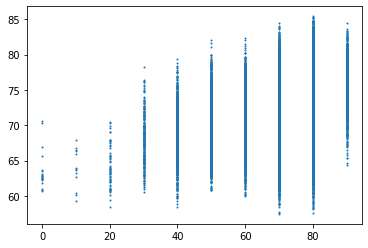

In [43]:
df_plot = pd.DataFrame([np.array(xgr_pred_pca).T, np.array(y_test_pca).T])
df_plot = df_plot.transpose()
df_plot = df_plot.sort_values([1]).reset_index(drop=True)
plt.scatter(df_plot[1], df_plot[0], s=1)



---



## Matrice de confusion

,1920,1932,1944,1956,1968,1980,1992,2004,2016,2028
1920,0,0,0,0,0,0,0,0,0,0
1932,0,0,0,0,0,0,0,0,0,0
1944,0,0,0,0,0,0,0,0,0,0
1956,0,0,0,0,0,0,0,0,0,0
1968,0,0,0,0,0,0,0,0,0,0
1980,0,0,0,0,0,0,0,0,0,0
1992,16,8,39,61,173,156,180,537,432,2
2004,4,5,22,206,950,2040,3630,8808,14056,420
2016,0,0,0,8,43,200,391,3235,15391,611
2028,0,0,0,0,0,0,0,0,5,0


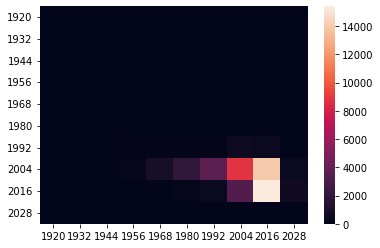

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(np.round_(np.array(xgr_pred_pca), decimals=-1), np.round_(np.array(y_test_pca), decimals=-1))

ind = list(range(1920,2040,12))
df_heat = pd.DataFrame(cf, index=ind, columns=ind)
len(ind)
# lab = pd.unique(df_heat[0])
sns.heatmap(df_heat)
df_heat
# df_plot.transpose().corr()